In [3]:
import numpy as np
import matplotlib as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [8., 5.]

In [98]:
class Polinomial:
    def __init__(self, coeffs):
        self.degree = len(coeffs) - 1
        self._c = coeffs
        assert self._c[self.degree] != 0
    def __call__(self, x):
        return sum([a * (x ** i) for (i, a) in enumerate(self._c)])
    def dx(self):
        return Polinomial([a * (i + 1) for (i, a) in enumerate(self._c[1:])])
    def plot(self, a, b):
        x = np.linspace(a, b, 100)
        y = x * 0
        for i, c in enumerate(self._c):
            y += c * (x ** i)
        plt.plot(x, x * 0)
        plt.plot(x, y)
        plt.show()

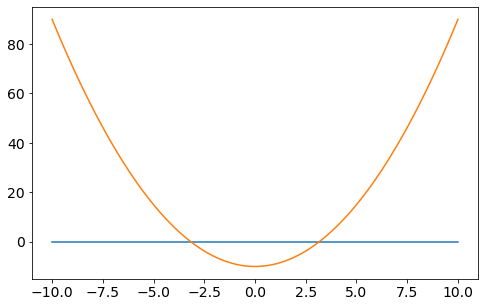

In [80]:
Polinomial([-10, 0, 1]).plot(-10, 10)

# Задание 2

In [142]:
# Функция делит отрезок [a, b] на отрезки [L1, R1] [L2, R2], ... 
# Такие, что p(L_i) * p(R_i) < 0
# Для этого она находит корни производной и проверяет их
def split_section(p, a, b, eps=1e-7):
    # Ну полиномы нулевой степени лучше сюда не передавать
    assert p.degree > 0
    # Если p(a) == 0 or p(b) == 0, невозможно разделить на интервалы из условия, не выкинув корень
    assert p(a) * p(b) != 0
    
    if p.degree == 1:
        root = -p._c[0] / p._c[1]
        if a <= root and root <= b:
            return [(a, b)]
        else:
            return []
    dp = p.dx()
    dp_roots = find_roots(dp, a, b)
    points = [a]
    for root in dp_roots:
        if close(p(root), 0, eps):
            # Если мы нашли корень, лучше отступить от него в разные стороны, чтобы 
            # Успешно делить на отрезки p(l_i) * p(r_i) < 0, а не p(l_i) * p(r_i) = 0
            # Это заставляет нас вводить отступ eps и считать, что корней ближе, чем на 2 * eps не бывает
            points.append(root-eps)
            points.append(root+eps)
        else:
            points.append(root)
    points.append(b)
    # Получили список [a, root_dp_1, root_dp_2, ..., b] - из него достанем нужные отрезки
    result = []
    for left, right in zip(points, points[1:]):
        if p(left) * p(right) < 0:
            result.append((left, right))
    return result
    
# Числа считаются равными с погрешностью eps 
def close(x, y, eps):
    return abs(x - y) <= eps

# Filter roots from list, so they in [a, b]
def filter_roots(roots, a, b):
    return list(filter(lambda x: a <= x and x <= b, roots))

def bisection(p, a, b, eps=1e-7):
    assert p(a) * p(b) < 0
    assert a < b and not close(a, b, eps)
    l, r = a, b
    while r - l > eps:
        m = (l + r) / 2
        if close(p(m), 0, eps):
            return m
        if p(l) * p(m) < 0:
            r = m
        else:
            l = m
    return l

def find_roots(p, a, b, eps=1e-7):
    
    # Analitical solution for degree 1 & 2
    if p.degree == 1:
        return filter_roots([-p._c[0] / p._c[1]], a, b)
    if p.degree == 2:
        pa = p._c[2]
        pb = p._c[1]
        pc = p._c[0]
        d = pb ** 2 - 4 * pa * pc
        if d < 0:
            return []
        else:
            x1 = (-pb - np.sqrt(d)) / (2 * pa)
            x2 = (-pb + np.sqrt(d)) / (2 * pa)
            return filter_roots([x1, x2], a, b)
        
    # TODO: Кратные корни скорее всего будут плохо искаться
    sections = split_section(p, a, b, eps)
    return [bisection(p, l, r, eps) for (l, r) in sections]

def find_minima(p, a, b, eps=1e-7):
    candidates = [(p(x), x) for x in find_roots(p.dx(), a, b, eps)] + [(p(a), a)] + [(p(b), b)]
    min_v, min_x = 10 ** 18, 0
    for v, x in candidates:
        if v < min_v:
            min_v = v
            min_x = x
    return min_v, min_x

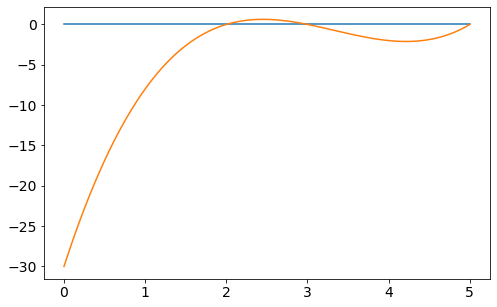

Section split from -10 to 10 : [(-10, 2.4514162296451363), (2.4514162296451363, 4.21525043702153), (4.21525043702153, 10)]
Roots from [-10, 10]: [2.0, 3.0000000000000027, 5.0]
Min value and argmin at [2, 10]: (-2.1126117909223723, 4.21525043702153)
Min value and argmin at [-10, 10]: (-2340, -10)


In [143]:
# (x - 5)(x - 3)(x - 2)
p = Polinomial([-30, 31, -10, 1])
p.plot(0, 5)
print(f'Section split from -10 to 10 : {split_section(p, -10, 10)}')
print(f'Roots from [-10, 10]: {find_roots(p, -10, 10, 1e-20)}')
print(f'Min value and argmin at [2, 10]: {find_minima(p, 2, 10)}')
print(f'Min value and argmin at [-10, 10]: {find_minima(p, -10, 10)}')

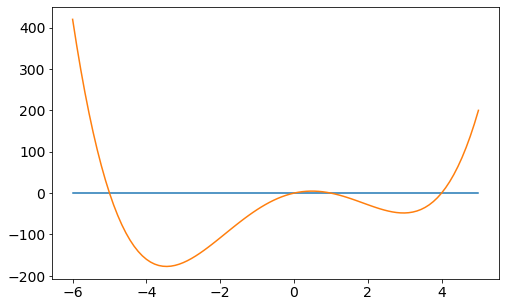

[(-10, -3.456385166537772), (-3.456385166537772, 0.48720443200795194), (0.48720443200795194, 2.969180638411098), (2.969180638411098, 10)]
[-5.0, -8.552106400880146e-17, 1.0, 4.0]
Min value and argmin at [-10, 10]: (-177.2850563435645, -3.456385166537772)


In [144]:
# (x + 5)(x - 4)(x - 1)x
# 20 x - 21 x^2 + x^4
p = Polinomial([0, 20, -21, 0, 1])
p.plot(-6, 5)
print(split_section(p, -10, 10))
print(find_roots(p, -10, 10, 1e-15))
print(f'Min value and argmin at [-10, 10]: {find_minima(p, -10, 10)}')

# Задание 1

In [165]:
import math
def newton(f, df, x0, max_iteration=10000, tolerance = 1e-7, epsilon = 1e-14):
    x1 = 0
    for _ in range(max_iteration):
        y = f(x0)
        ydx = df(x0)

        if abs(ydx) < epsilon:
            break

        x0 = x0 - y / ydx
        if abs(f(x0)) <= tolerance:
            return x0
    # Can't reach the solution
    assert(False)
    
def newton_ak(a: float, k: int):
    # x^0 - a ?
    assert k != 0
    # x^k + a ?
    assert a >= 0
    if k == 1 or a == 0 or a == 1:
        # 0^0 == 0
        return a
    # x^(-k) - 0 ?
    assert k >= 0 or a != 0
    if k < 0:
        return newton_ak(1 / a, -k)
    if k < 1:
        floor = math.floor(1 / k)
        q = 1 / k - floor
        # We can find a^(int) without newton, right?
        return (a ** floor) * newton_ak(a, q)
    x0 = a
    f = lambda x: x ** k - a
    df = lambda x: k * (x ** (k - 1))
    return newton(f, df, x0)

def bisection_ak(a: float, k: int):
    # Taken from task 2
    return bisection(lambda x: x ** k - a, 0, a + 1)

In [168]:
for a in range(1, 100):
    for k in range(1, 100):
        assert(close(newton_ak(a, k), a ** (1/k), eps=1e-6))
        assert(close(bisection_ak(a, k), a ** (1/k), eps=1e-6))

# Задание 3

In [195]:
# a, b, c > 0 => Нетрудно проверить, что f'' >= 0 и функция выпуклая
# Достаточно найти корень производной
def get_fs(a, b, c, d):
    f = lambda x: np.exp(a * x) + np.exp(-b*x) + c * ((x - d) ** 2)
    df = lambda x: a * np.exp(a * x) - b * np.exp(-b * x) + 2 * c * (x - d)
    ddf = lambda x: a * a * np.exp(a * x) + b * b * np.exp(-b * x) + 2 * c
    return f, df, ddf

In [186]:
def min_newton(a, b, c, d, eps):
    x0 = (a + b + c + d) / 4
    _, df, ddf = get_fs(a, b, c, d)
    # Newton from task 1
    return newton(df, ddf, x0, tolerance=eps)

In [207]:
def min_bisection(a, b, c, d, eps):
    _, df, ddf = get_fs(a, b, c, d)
    bound = max(abs(a), abs(b), abs(c), abs(d), 2) * 10
    return bisection(df, -bound, bound, eps)

In [213]:
def ternary_search(f, l, r, eps):
    assert l < r
    while(r - l > eps):
        m1 = l + (r - l) / 3
        m2 = l + 2 * (r - l) / 3
        if f(m1) < f(m2):
            r = m2
        else:
            l = m1
    return (l + r) / 2
def min_ternary(a, b, c, d, eps):
    f, _, _ = get_fs(a, b, c, d)
    bound = max(abs(a), abs(b), abs(c), abs(d), 2) * 10
    return ternary_search(f, -bound, bound, eps)

In [220]:
eps = 1e-9
print(min_newton(1, 2, 3, 4, eps))
print(min_bisection(1, 2, 3, 4, eps))
print(min_ternary(1, 2, 3, 4, eps))

2.315283729985808
2.3152837296947837
2.315283747486209
